# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import matplotlib.pyplot as plt

# EDA

In [2]:
df = pd.read_csv('compas_people.csv')
df

,id,name,first,last,sex,race,dob,age,age_cat,juv_fel_count,...,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,is_violent_recid,num_vr_cases,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc
0,1,miguel hernandez,miguel,hernandez,Male,Other,1947-04-18 00:00:00.000000,69,Greater than 45,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2,michael ryan,michael,ryan,Male,Caucasian,1985-02-06 00:00:00.000000,31,25 - 45,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,3,kevon dixon,kevon,dixon,Male,African-American,1982-01-22 00:00:00.000000,34,25 - 45,0,...,2013-07-05 00:00:00.000000,Felony Battery (Dom Strang),NaN,NaN,1,NaN,13009779CF10A,(F3),2013-07-05 00:00:00.000000,Felony Battery (Dom Strang)
3,4,ed philo,ed,philo,Male,African-American,1991-05-14 00:00:00.000000,24,Less than 25,0,...,2013-06-16 00:00:00.000000,Driving Under The Influence,2013-06-16 09:05:47.000000,2013-06-16 07:18:55.000000,0,NaN,NaN,NaN,NaN,NaN
4,5,marcu brown,marcu,brown,Male,African-American,1993-01-21 00:00:00.000000,23,Less than 25,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11752,11753,patrick hamilton,patrick,hamilton,Male,Other,1968-05-02 00:00:00.000000,47,Greater than 45,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
11753,11754,raymond hernandez,raymond,hernandez,Male,Caucasian,1993-06-24 00:00:00.000000,22,Less than 25,0,...,2014-10-11 00:00:00.000000,Driving License Suspended,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
11754,11755,dieuseul pierre-gilles,dieuseul,pierre-gilles,Male,Other,1981-01-24 00:00:00.000000,35,25 - 45,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
11755,11756,scott lomagistro,scott,lomagistro,Male,Caucasian,1986-12-04 00:00:00.000000,29,25 - 45,0,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [3]:
df = df.drop(['name', 'first', 'last', 
              'score_text', 'violent_recid', 'c_case_number', 
              'c_offense_date', 'c_charge_desc', 'r_case_number', 
              'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 
              'r_charge_desc', 'r_jail_in', 'r_jail_out', 
              'is_violent_recid', 'num_vr_cases', 'vr_case_number', 
              'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
              'c_arrest_date', 'dob', 'days_b_screening_arrest',
              'c_days_from_compas', 'id', 'compas_screening_date',
              'num_r_cases'], axis=1)

In [4]:
df['jail_time'] = (pd.to_datetime(df.c_jail_out) - pd.to_datetime(df.c_jail_in)).astype("timedelta64[s]")
df.jail_time.fillna(0, inplace=True)
df.drop(['c_jail_in', 'c_jail_out'], axis=1, inplace=True)

In [5]:
df.c_charge_degree.fillna('Z', inplace=True)

In [6]:
df = df[df.is_recid != -1]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11038 entries, 0 to 11756
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              11038 non-null  object 
 1   race             11038 non-null  object 
 2   age              11038 non-null  int64  
 3   age_cat          11038 non-null  object 
 4   juv_fel_count    11038 non-null  int64  
 5   juv_misd_count   11038 non-null  int64  
 6   juv_other_count  11038 non-null  int64  
 7   decile_score     11038 non-null  int64  
 8   priors_count     11038 non-null  int64  
 9   c_charge_degree  11038 non-null  object 
 10  is_recid         11038 non-null  int64  
 11  jail_time        11038 non-null  float64
dtypes: float64(1), int64(7), object(4)
memory usage: 1.1+ MB


In [8]:
needs_scaling = df.drop(['sex', 'race', 'age_cat', 'c_charge_degree', 'is_recid'], axis=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(needs_scaling)

needs_encoding = df[['sex', 'race', 'age_cat', 'c_charge_degree']]
enc = OneHotEncoder(sparse=False)
one_hot_data = enc.fit_transform(needs_encoding)

transformed_data = np.concatenate((scaled_data, one_hot_data), axis=1)

In [15]:
# encoded_df.reset_index(drop=True, inplace=True)
# one_hot_df.reset_index(drop=True, inplace=True)
# encoded_df = pd.concat([encoded_df, one_hot_df], axis=1)

In [16]:
# encoded_df

In [17]:
y = df['is_recid'].values
# encoded_df.drop('is_recid', axis=1, inplace=True)
x = transformed_data

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)

train_df = pd.DataFrame([])
combo_df = pd.DataFrame([])
test_df = pd.DataFrame([])
valid_df = pd.DataFrame([])

for train_index, combo_index in sss.split(x, y):
    train_x, combo_x = x[train_index], x[combo_index]
    train_y, combo_y = y[train_index], y[combo_index]
    train_df = train_df.append(df.iloc[train_index])
    combo_df = combo_df.append(df.iloc[combo_index])
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)

for test_index, valid_index in sss.split(combo_x, combo_y):
    test_x, valid_x = combo_x[test_index], combo_x[valid_index]
    test_y, valid_y = combo_y[test_index], combo_y[valid_index]
    test_df = test_df.append(combo_df.iloc[test_index])
    valid_df = valid_df.append(combo_df.iloc[valid_index])

Last but not least we define a couple helper methods.

In [18]:
best_model = {'acc': 0}

# Tracks model with highest accuracy
def update_best_model(acc, name, model, params):
    if (acc > best_model['acc']):
        best_model['acc'] = acc
        best_model['name'] = name
        best_model['model'] = model
        best_model['params'] = params

# Performs a grid search on a passed-in classifier
def run_grid_search(folds, params, clf, name):
    gscv = GridSearchCV(clf, params, cv=folds)
    gscv.fit(train_x, train_y)
    acc = accuracy_score(test_y, gscv.predict(test_x))
    update_best_model(acc, name, gscv, gscv.best_params_)

# Algorithm Testing

## KNN

In [19]:
folds = 10
params = {'n_neighbors': list(range(3, 16))}

run_grid_search(folds, params, KNeighborsClassifier(), 'KNN')

## Trees

### Decision Tree

In [20]:
folds = 10
params = {'criterion': ('entropy', 'gini'),
         'max_depth': [2, 3, 4, 5, 6, 7, 8]}

run_grid_search(folds, params, DecisionTreeClassifier(), 'Decision Tree')

### Random Forest

In [21]:
folds = 10
params = {'criterion': ('entropy', 'gini'),
         'max_depth': [2, 3, 4, 5, 6, 7, 8],
         'n_estimators': [10, 20, 30, 40]}

run_grid_search(folds, params, RandomForestClassifier(), 'Random Forest')

## Logistic Regression

In [22]:
folds = 10
params = {'penalty': ['l1', 'l2'],
             'C': [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000]}

run_grid_search(folds, params, LogisticRegression(solver='liblinear'), 'Logistic Regression')

## DNN

In [23]:
train_x = tf.dtypes.cast(train_x, tf.float64)
test_x = tf.dtypes.cast(test_x, tf.float64)
valid_x = tf.dtypes.cast(valid_x, tf.float64)

train_y = tf.dtypes.cast(train_y, tf.int64)
test_y = tf.dtypes.cast(test_y, tf.int64)
valid_y = tf.dtypes.cast(valid_y, tf.int64)

In [24]:
%load_ext tensorboard

In [25]:
from tensorboard.plugins.hparams import api as hp

In [26]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([40, 80, 120]))
HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete([1]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'rmsprop']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_NUM_LAYERS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

## Notes

- Adding loss weights doesn't really affect accuracy but *can* massively decrease loss, for some reason. [0.2, 3] reduces loss from ~0.5 all the way down to 0.1-0.12 range
- Deriving the loss weights from the dataset itself doesn't seem to make much of a difference
- Messing around with the loss function doesn't really do much

In [27]:
def train_test_model(hparams):

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten())

  for i in range(hparams[HP_NUM_LAYERS]):
        model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu))
        
  model.add(tf.keras.layers.Dropout(hparams[HP_DROPOUT]))
  model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
#       loss_weights=[0.2,3],
  )
    
  model.fit(train_x, train_y, epochs=5) # Run with 1 epoch to speed things up for demo purposes
  _, accuracy = model.evaluate(test_x, test_y)
    
  update_best_model(accuracy, 'DNN', model, hparams)

  return accuracy

In [28]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [29]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        for num_layers in HP_NUM_LAYERS.domain.values:
          hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
              HP_NUM_LAYERS: num_layers,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
{'num_units': 40, 'dropout': 0.1, 'optimizer': 'adam', 'num_layers': 1}
Epoch 1/5
242/242 [==============================] - 1s 2ms/step - loss: 0.6068 - accuracy: 0.6794
Epoch 2/5
242/242 [==============================] - 0s 1ms/step - loss: 0.5783 - accuracy: 0.6971
Epoch 3/5
242/242 [==============================] - 0s 1ms/step - loss: 0.5758 - accuracy: 0.6998
Epoch 4/5
242/242 [==============================] - 0s 1ms/step - loss: 0.5722 - accuracy: 0.7020
Epoch 5/5
52/52 [==============================] - 0s 863us/step - loss: 0.5724 - accuracy: 0.7083
--- Starting trial: run-1
{'num_units': 40, 'dropout': 0.1, 'optimizer': 'rmsprop', 'num_layers': 1}
Epoch 1/5
242/242 [==============================] - 1s 2ms/step - loss: 0.6013 - accuracy: 0.6841
Epoch 2/5
242/242 [==============================] - 0s 1ms/step - loss: 0.5779 - accuracy: 0.7008
Epoch 3/5
242/242 [==============================] - 0s 1ms/step - loss: 0.5764 - accuracy: 0.7001
Epoch 4/5

In [30]:
%tensorboard --logdir logs/hparam_tuning --host localhost

Reusing TensorBoard on port 6006 (pid 13816), started 2 days, 20:03:26 ago. (Use '!kill 13816' to kill it.)

# Results

In [69]:
print('Best Model:', best_model['name'], '\nAccuracy:', best_model['acc']) 

if (best_model['name'] == 'DNN'):
    print('Parameters:', best_model['params'].values())
else:
    print('Parameters:', best_model['params'])

Best Model: DNN 
Accuracy: 0.7119565010070801
Parameters: dict_values([80, 0.2, 'adam', 1])


Now, let's test our best model against our validation set and see how it does.

In [32]:
prediction = best_model['model'].predict(valid_x)
if (best_model['name'] == 'DNN'):
    prediction = np.argmax(prediction, axis=1)
    _, valid_acc = best_model['model'].evaluate(valid_x, valid_y)
else:
    valid_acc = accuracy_score(valid_y, prediction)

valid_acc

52/52 [==============================] - 0s 2ms/step - loss: 0.5694 - accuracy: 0.7126


0.7125604152679443

In [71]:
def get_diff_dict(column):
    predict_df = valid_df.copy(deep=True)   
    predict_df[column] = prediction

    yes_predict_df = predict_df[predict_df[column] == 1]
    yes_valid_df = valid_df[valid_df[column] == 1]

    no_predict_df = predict_df[predict_df[column] == 0]
    no_valid_df = valid_df[valid_df[column] == 0]

    return {'Validation Set': valid_df, 'Prediction Set': predict_df,
              'Validation where Recidivism=True': yes_valid_df, 'Prediction where Recidivism=True': yes_predict_df,
              'Validation where Recidivism=False': no_valid_df, 'Prediction where Recidivism=False': no_predict_df}
    
    
diff_dict = get_diff_dict('is_recid')
diff_values = list(diff_dict.values())

<function matplotlib.pyplot.show(close=None, block=None)>

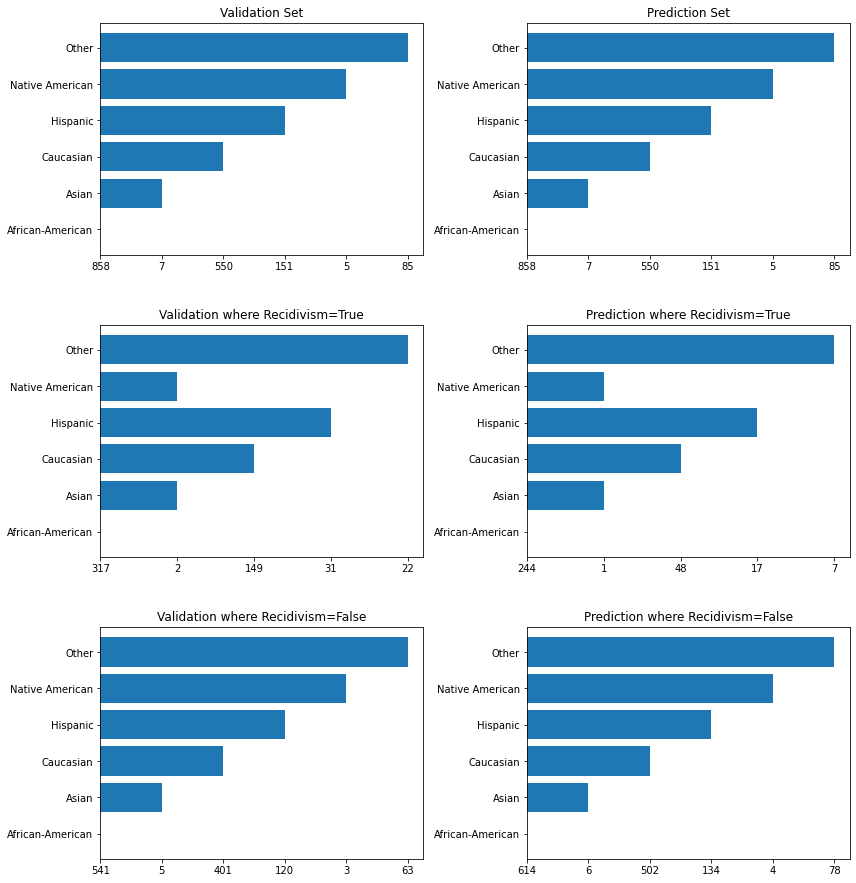

In [72]:
fig = plt.figure(figsize=(12, 8))
i = 1
for k, v in diff_dict.items():
    ax = fig.add_subplot(3,2,i)
    ax.barh(v.sort_values('race')['race'].unique(), v.sort_values('race')['race'].value_counts(sort=False).astype(str))
    ax.set_title(k)
    i += 1
fig.tight_layout()
plt.subplots_adjust(top=1.5)
plt.show

In [73]:
def compare_ethnic_spread(base_df, hyp_df):
    base_ethnicity_spread = base_df['race'].value_counts(normalize=True)
    hyp_ethnicity_spread = hyp_df['race'].value_counts(normalize=True)

    
    print(
'''ACTUAL:
{}\n\n
PREDICTED:
{}\n
DIFFERENCE:'''.format(base_ethnicity_spread, hyp_ethnicity_spread))
    
    diff = dict()
    for race in hyp_df['race'].unique():
        diff[race] = hyp_ethnicity_spread[race] - base_ethnicity_spread[race]
        
    print("\n".join("{:>17}  {:>8.5f}".format(k, v) for k, v in diff.items()))

In [74]:
print("Comparing full validation set vs. full prediction set\n")
compare_ethnic_spread(diff_values[0], diff_values[1])

Comparing full validation set vs. full prediction set

ACTUAL:
African-American    0.518116
Caucasian           0.332126
Hispanic            0.091184
Other               0.051329
Asian               0.004227
Native American     0.003019
Name: race, dtype: float64


PREDICTED:
African-American    0.518116
Caucasian           0.332126
Hispanic            0.091184
Other               0.051329
Asian               0.004227
Native American     0.003019
Name: race, dtype: float64

DIFFERENCE:
         Hispanic   0.00000
 African-American   0.00000
            Other   0.00000
        Caucasian   0.00000
            Asian   0.00000
  Native American   0.00000


In [75]:
print("Comparing subsets where recidivism was true\n")
compare_ethnic_spread(diff_values[2], diff_values[3])

Comparing subsets where recidivism was true

ACTUAL:
African-American    0.606119
Caucasian           0.284895
Hispanic            0.059273
Other               0.042065
Asian               0.003824
Native American     0.003824
Name: race, dtype: float64


PREDICTED:
African-American    0.767296
Caucasian           0.150943
Hispanic            0.053459
Other               0.022013
Native American     0.003145
Asian               0.003145
Name: race, dtype: float64

DIFFERENCE:
 African-American   0.16118
            Other  -0.02005
        Caucasian  -0.13395
         Hispanic  -0.00581
  Native American  -0.00068
            Asian  -0.00068


In [76]:
print("Comparing subsets where recidivism was false\n")
compare_ethnic_spread(diff_values[4], diff_values[5])

Comparing subsets where recidivism was false

ACTUAL:
African-American    0.477493
Caucasian           0.353928
Hispanic            0.105914
Other               0.055605
Asian               0.004413
Native American     0.002648
Name: race, dtype: float64


PREDICTED:
African-American    0.458894
Caucasian           0.375187
Hispanic            0.100149
Other               0.058296
Asian               0.004484
Native American     0.002990
Name: race, dtype: float64

DIFFERENCE:
         Hispanic  -0.00576
 African-American  -0.01860
        Caucasian   0.02126
            Other   0.00269
            Asian   0.00007
  Native American   0.00034
